In [57]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy import optimize

matplotlib.rc('font', size=16)

# adsorption model $\mathbf{m}(\mathbf{p})$

In [24]:
# Langmuir params for MOF 1
K1 = [0.1, 0.5]
M1 = 1.0
# Langmuir params for MOF 2
K2 = [0.7, 0.3]
M2 = 2.0

def m_1(p):
    return M1 * np.dot(K1, p) / (1 + np.dot(K1, p))

def m_2(p):
    return M2 * np.dot(K2, p) / (1 + np.dot(K2, p))

# inverse of adsorption model $\mathbf{p}(\mathbf{m})$

nan

In [63]:
def p_of_m(m_0, p_lb, p_ub):
    # we want this function to return a zero vector
    #  it takes in a pressure p
    #  it outputs the corresponding difference between the response and the response m_0 that we find
    #  if we find the right p that gives us the response m_0, then this will be the zero vector
    def f(p):
        return [m_1(p) - m_0[0], m_2(p) - m_0[1]]
    sol = optimize.root(f, [1.0, 1.0])
    p = sol.x
    # return nan if p less than lower bound, greater than upper bound
    if p[1] < 0.0 or p[0] < 0.0:
        return np.array([np.nan, np.nan])
    if not sol.success:
        return np.array([np.nan, np.nan])
#     assert np.all(np.isclose([m_1(p), m_2(p)], m_0))
    return p

p_of_m([0.2, 0.5])

array([0.28645833, 0.44270833])

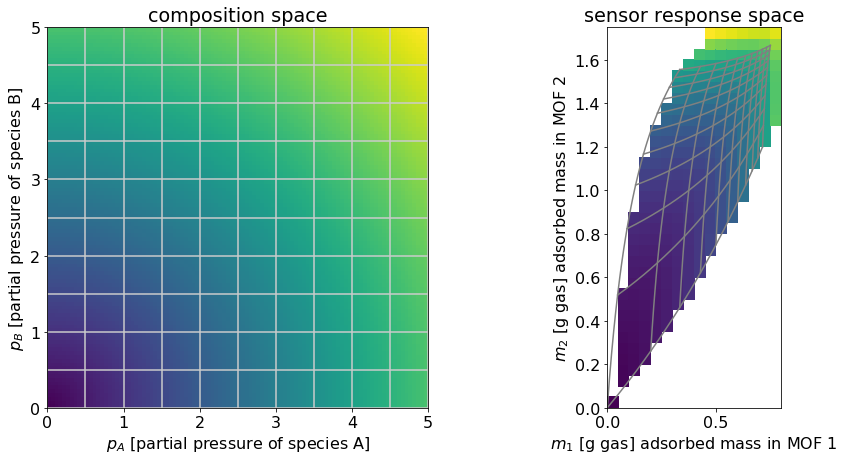

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].set_title("composition space")
ax[0].set_xlabel("$p_A$ [partial pressure of species A]")
ax[0].set_ylabel("$p_B$ [partial pressure of species B]")

# shared params
p_max = 5.0 # largest pressure we go to.

###
#   sensor response space
###
ax[1].set_aspect('equal', 'box')
ax[1].set_title("sensor response space")
ax[1].set_xlabel("$m_1$ [g gas] adsorbed mass in MOF 1")
ax[1].set_ylabel("$m_2$ [g gas] adsorbed mass in MOF 2")

###
#   draw grid lines and their mapping
###
dp = 0.5 # spacing between grid lines
nb_pts = 50
# these arrays will contain the correponding reponses to each point on the lines.
m1 = np.zeros(nb_pts)
m2 = np.zeros(nb_pts)
for i in range(int(p_max / dp)+1):
    ###
    #   x = constant (vertical) grid lines
    ###
    p_a = i * dp # p_a is constant here.
    # plot the line in composition space
    ax[0].plot([p_a, p_a], [0, p_max], color="0.8")
    
    # plot the image of the line in sensor response space
    p_b = np.linspace(0.0, p_max, nb_pts)

    # loop through points on the line
    for j in range(nb_pts):
        # get vector on this line
        p_on_line = [p_a, p_b[j]]
        # compute the adsorbed mass in the two MOFs when exposed to this gas composition
        m1[j] = m_1(p_on_line)
        m2[j] = m_2(p_on_line)
    ax[1].plot(m1, m2, color="gray")
    
    ###
    #   y = constant (horizontal) grid lines
    ###
    p_b = i * dp # p_b is constant here.
    # plot the line in composition space
    ax[0].plot([0, p_max], [p_b, p_b], color="0.8")
    
    # plot the image of the line in sensor response space
    p_a = np.linspace(0.0, p_max, nb_pts)

    # loop through points on the line
    for j in range(nb_pts):
        # get vector on this line
        p_on_line = [p_a[j], p_b]
        # compute the adsorbed mass in the two MOFs when exposed to this gas composition
        m1[j] = m_1(p_on_line)
        m2[j] = m_2(p_on_line)
    ax[1].plot(m1, m2, color="gray")
    
    
###
#   color the plane
#   color represents.
###
# make these smaller to increase the resolution
dp = 0.05
dm = 0.05

# lay a grid in composition space
pb, pa = np.mgrid[slice(0, p_max + dp, dp),
                  slice(0, p_max + dp, dp)]
# lay a grid in response space
m1, m2 = np.mgrid[slice(0, ax[1].get_xlim()[1] + dm, dm),
                  slice(0, ax[1].get_ylim()[1] + dm, dm)]

z_composition = np.sqrt(pb ** 2 + pa ** 2)
z_response = np.zeros(np.shape(m1))
for i in range(np.shape(z_response)[0]):
    for j in range(np.shape(z_response)[1]):
        m_0 = [m1[i, j], m2[i, j]]
        p = p_of_m(m_0)
        z_response[i, j] = np.linalg.norm(p)

ax[0].pcolormesh(pa, pb, z_composition)
ax[1].pcolormesh(m1, m2, z_response)
    
ax[1].set_aspect('equal', 'box')
ax[0].set_aspect('equal', 'box')

In [46]:
np.shape(m1)

(17, 36)

In [47]:
np.shape(m2)

(17, 36)

In [36]:
np.zeros((np.size(m1), np.size(m2)))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

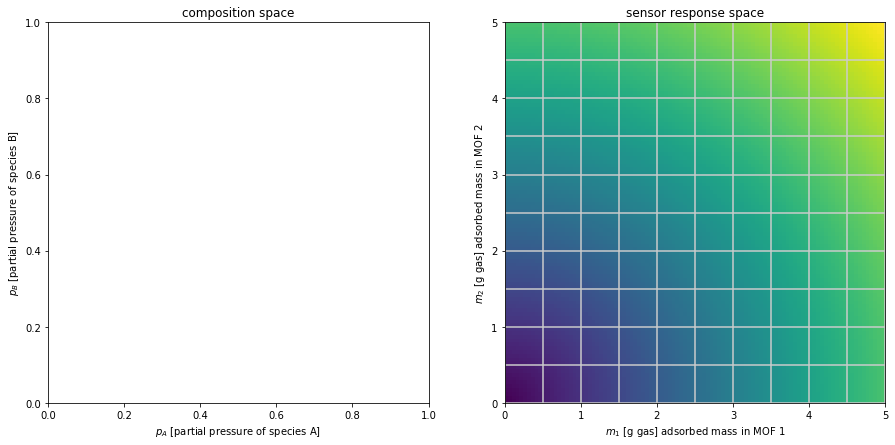

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].set_title("composition space")
ax[0].set_xlabel("$p_A$ [partial pressure of species A]")
ax[0].set_ylabel("$p_B$ [partial pressure of species B]")

# shared params
p_max = 5.0 # largest pressure we go to.

###
#   sensor response space
###
ax[1].set_aspect('equal', 'box')
ax[1].set_title("sensor response space")
ax[1].set_xlabel("$m_1$ [g gas] adsorbed mass in MOF 1")
ax[1].set_ylabel("$m_2$ [g gas] adsorbed mass in MOF 2")

###
#   draw grid lines and their mapping
###
dp = 0.5 # spacing between grid lines
nb_pts = 50
# these arrays will contain the correponding reponses to each point on the lines.
m1 = np.zeros(nb_pts)
m2 = np.zeros(nb_pts)
for i in range(int(p_max / dp)+1):
    ###
    #   x = constant (vertical) grid lines
    ###
    p_a = i * dp # p_a is constant here.
    # plot the line in composition space
    ax[1].plot([p_a, p_a], [0, p_max], color="0.8")
    
    ###
    #   y = constant (horizontal) grid lines
    ###
    p_b = i * dp # p_b is constant here.
    # plot the line in composition space
    ax[1].plot([0, p_max], [p_b, p_b], color="0.8")
    
    
###
#   color the plane
#   color represents.
###
# make these smaller to increase the resolution
dp = 0.05

# generate 2 2d grids for the x & y bounds
pb, pa = np.mgrid[slice(0, p_max + dp, dp),
                slice(0, p_max + dp, dp)]

z = np.sqrt(pb ** 2 + pa ** 2)

ax[1].pcolormesh(pa, pb, z)
    

    
ax[1].set_aspect('equal', 'box')
ax[0].set_aspect('equal', 'box')